<a href="https://colab.research.google.com/github/sreejakr/EEG-Emotion-Detection/blob/main/Seizure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! rmdir

rmdir: missing operand
Try 'rmdir --help' for more information.


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Projects/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c seizure-detection

100% 10.1G/10.1G [07:14<00:00, 29.9MB/s]
100% 10.1G/10.1G [07:14<00:00, 25.0MB/s]


In [ ]:
! unzip seizure-detection

Archive:  seizure-detection.zip
  inflating: clips.tar.gz            
  inflating: sampleSubmission.csv    
  inflating: sample_clip.mat.gz      


In [ ]:
!pip install mne


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import scipy.io
import zipfile
import os
import re
import mne

import tarfile
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

In [ ]:
tar_gz_file = 'clips.tar.gz'
mat_gz_file = 'clip.mat.gz'
extracted_dir_path = "/content/dataset"

if not os.path.exists(extracted_dir_path):
    os.makedirs(extracted_dir_path)

with tarfile.open(tar_gz_file, 'r:gz') as tar:
    tar.extractall(extracted_dir_path)

Pick out a random ictal and interictal from each patient. Then convert the files to a dataframe (channels specified in mat file) which used for making an mne object. Ictal and interictal graphs are then analysed for all the patients.

In [ ]:
import random

def find_ictal_and_interictal(folder_path):
    ictal_files = []
    interictal_files = []
    test_files = []

    for file_name in os.listdir(folder_path):
        if file_name.lower().find("_ictal")!=-1:
            ictal_files.append(os.path.join(folder_path, file_name))
        elif file_name.lower().find("_interictal")!=-1:
            interictal_files.append(os.path.join(folder_path, file_name))

    print(interictal_files)
    if  len(ictal_files) ==0 or len(interictal_files)==0:
        return None, None

    return ictal_files, interictal_files


In [ ]:
def mat_to_df(path):
  mat = scipy.io.loadmat(path)
  channels = mat['channels']
  channels_list = []
  for channel_array in channels[0][0]:
    channels_list.append(channel_array[0])
  df = pd.DataFrame(mat['data'],
                    index=channels_list)
  df = df.T
  df = df.loc[:, (df != df.iloc[0]).any()]
  return df, mat['freq'][0]

Structure of the mat file -

data: A NumPy array containing the EEG data. Each row represents a different channel, and each column represents a sample at a specific time. The values in the array represent the amplitude of the EEG signal.

freq: A NumPy array containing a single value (5000.0), indicating the frequency of the EEG data in Hertz.

channels: A structured NumPy array with a single field. Each field is a tuple containing arrays of strings representing the channel names. The channels are categorized into different types such as 'ATD' (presumably referring to some type of electrode or sensor), 'ITS', 'LFS', 'LG', 'PTD', and 'STS'.

For example, the first tuple in the 'channels' array corresponds to the 'ATD' type and contains arrays with channel names like 'ATD_1', 'ATD_2', ..., 'ITS_4', etc.

Each channel name is associated with a data type 'O' (object), indicating that the data type of each element in the array is an object.

In [ ]:
mat = scipy.io.loadmat("/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_315.mat")
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: unix, Software: R v3.0.2, Created on: Mon Apr  7 23:33:36 2014',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[ 24.0954,  24.0954,  24.0954, ...,  30.0954,  30.0954,  30.0954],
        [ 37.3484,  37.3484,  36.3484, ...,  10.3484,  10.3484,   9.3484],
        [ 56.718 ,  56.718 ,  55.718 , ..., -11.282 , -11.282 , -11.282 ],
        ...,
        [-23.6736, -23.6736, -24.6736, ..., -13.6736, -13.6736, -14.6736],
        [-11.3518, -11.3518, -12.3518, ..., -21.3518, -20.3518, -21.3518],
        [-18.3772, -16.3772, -16.3772, ...,  -8.3772,  -6.3772,  -6.3772]]),
 'freq': array([5000.]),
 'channels': array([[(array(['ATD_1'], dtype='<U5'), array(['ATD_2'], dtype='<U5'), array(['ATD_3'], dtype='<U5'), array(['ATD_4'], dtype='<U5'), array(['ITS_1'], dtype='<U5'), array(['ITS_2'], dtype='<U5'), array(['ITS_3'], dtype='<U5'), array(['ITS_4'], dtype='<U5'), array(['LFS_1'], dtype='<U5'), array(['LFS_2'], dtype='<U5'), array(['LFS_3'

In [ ]:
def create_mne_object(data, freq):
    # Create an MNE info file with meta data about the EEG
    info = mne.create_info(ch_names=list(data.columns),
                           sfreq=freq,
                           ch_types=['eeg'] * data.shape[-1])

    # Convert data to volts (from microvolts)
    data = data.apply(lambda x: x * 1e-6)
    data_T = data.transpose()
    raw = mne.io.RawArray(data_T, info)

    return raw

# Plot parameters
args = {
    'scalings': dict(eeg=20e-5),
    'highpass': 0.5,
    'lowpass': 70.,
    'show_scrollbars': False,
    'show': True,
}


/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_52.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_85.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_70.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_46.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_77.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_17.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_90.mat', '/content/dataset/Volumes/Seagate/seizure_detection/co

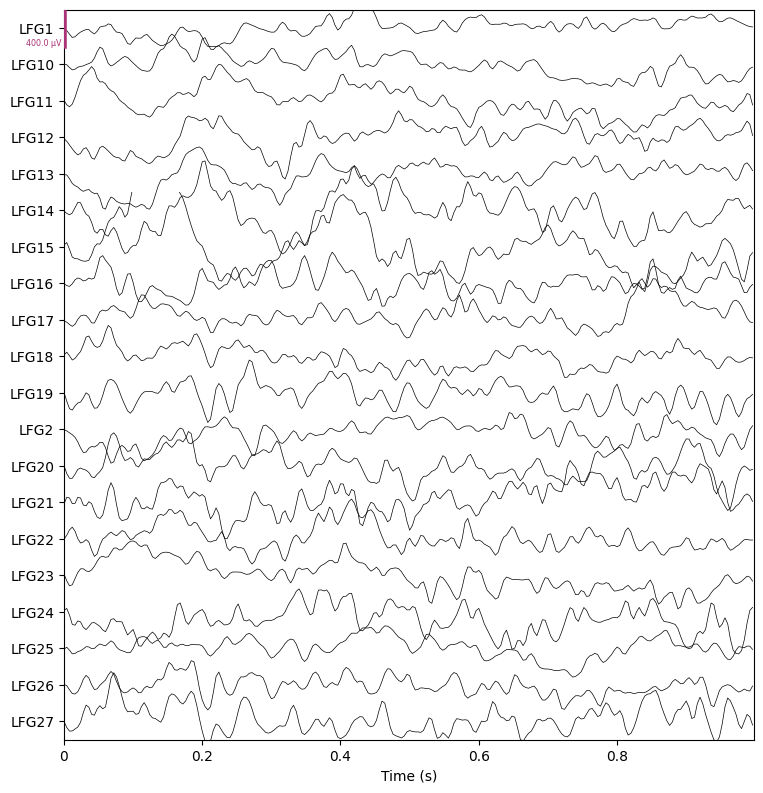

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_1/Patient_1_interictal_segment_91.mat
Creating RawArray with float64 data, n_channels=68, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



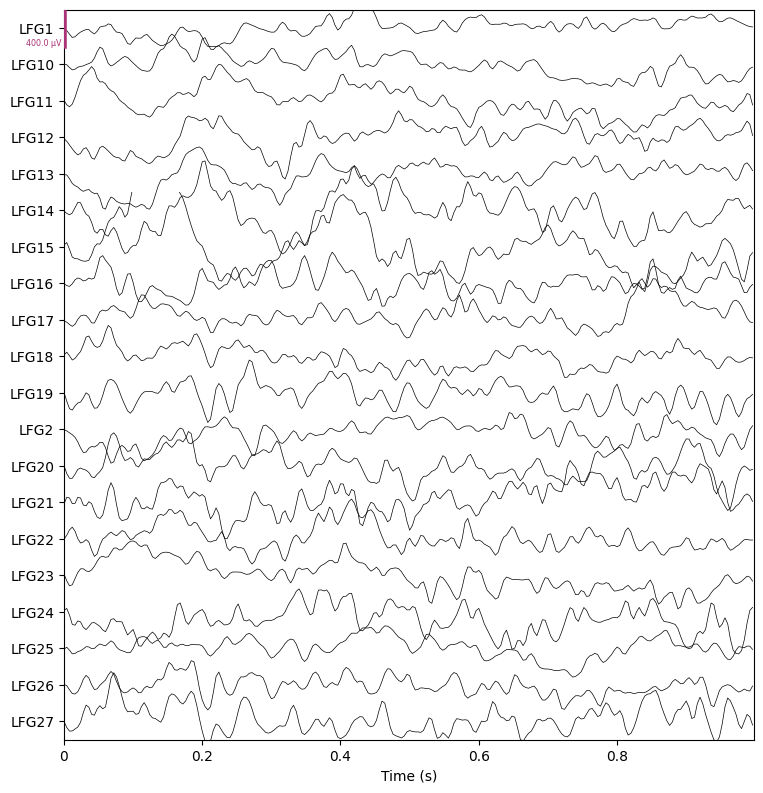

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_4669.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_1840.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_1896.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_4653.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_4224.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_2196.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_2147.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_se

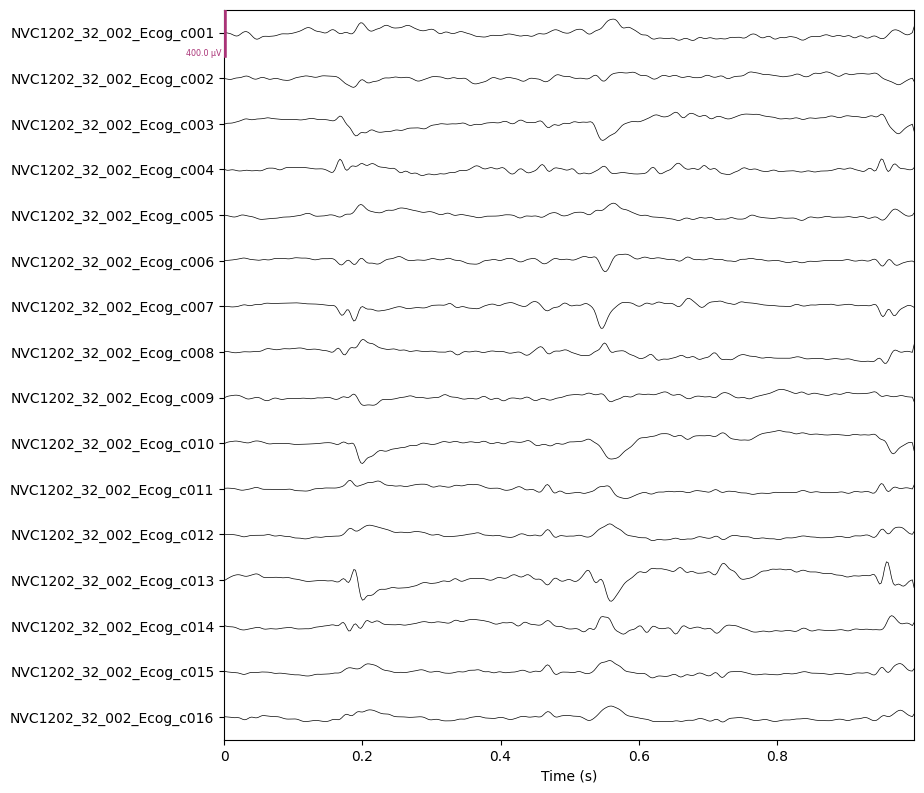

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_3/Dog_3_interictal_segment_358.mat
Creating RawArray with float64 data, n_channels=16, n_times=400
    Range : 0 ... 399 =      0.000 ...     0.998 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



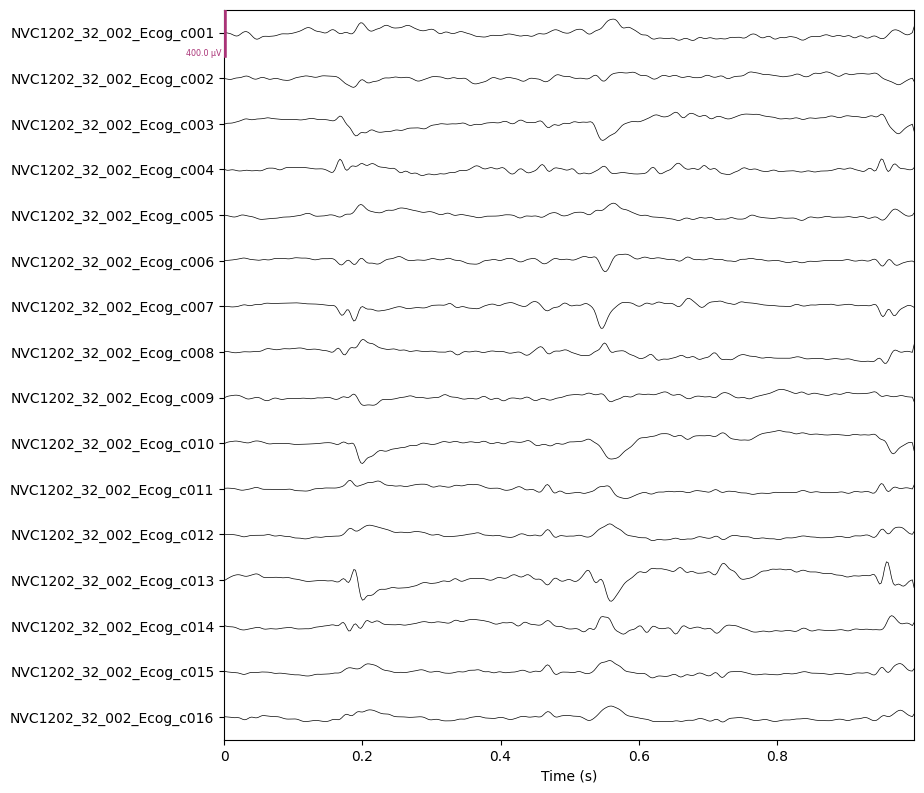

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_268.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_202.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_62.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_699.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_408.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_146.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_409.mat', '/content/dataset/Volumes/Seagate/seizure_detect

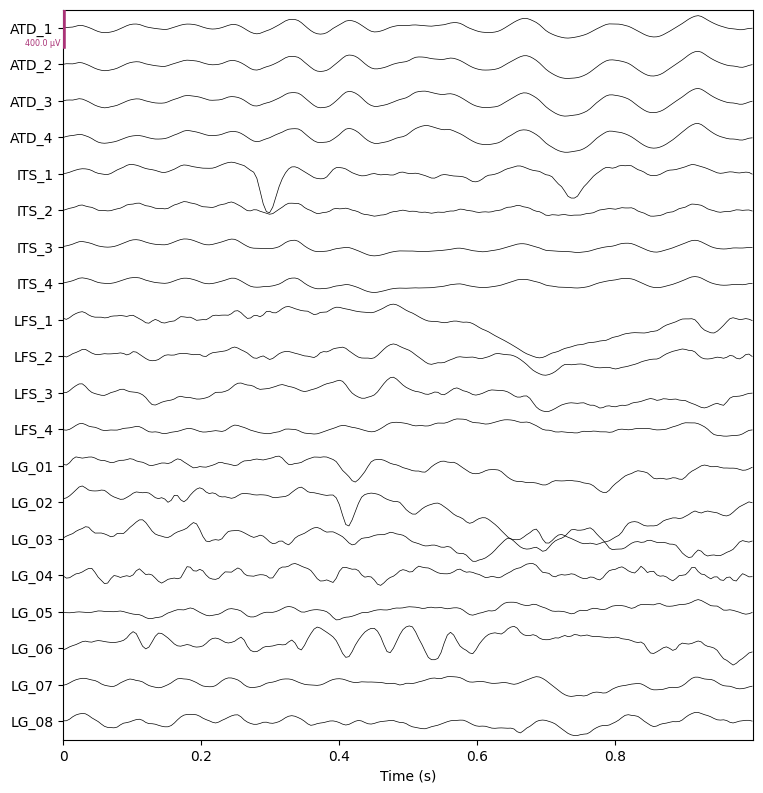

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_3/Patient_3_interictal_segment_29.mat
Creating RawArray with float64 data, n_channels=55, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



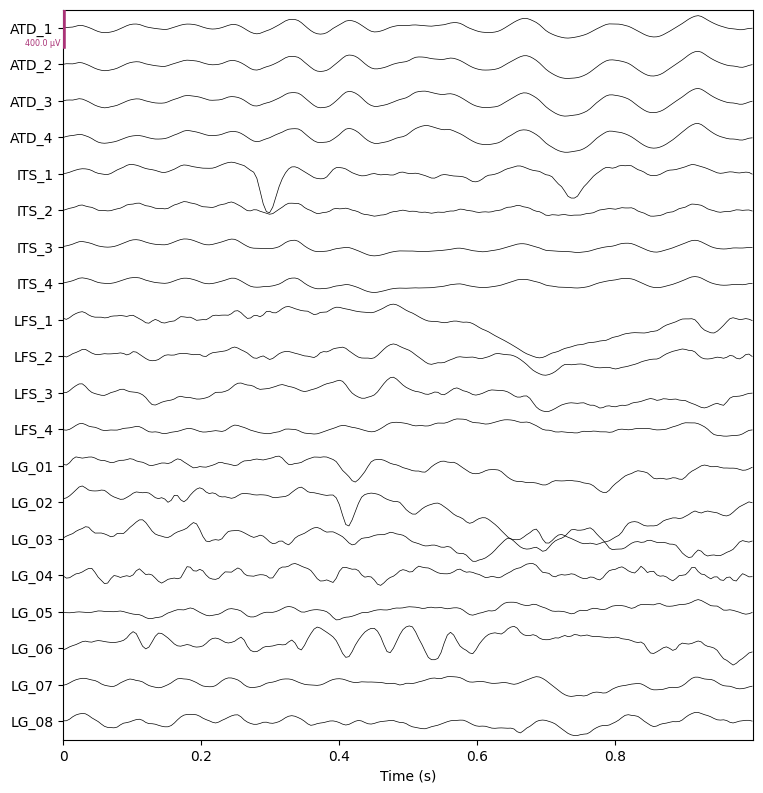

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_162.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_50.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_29.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_170.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_219.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_158.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_368.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_173

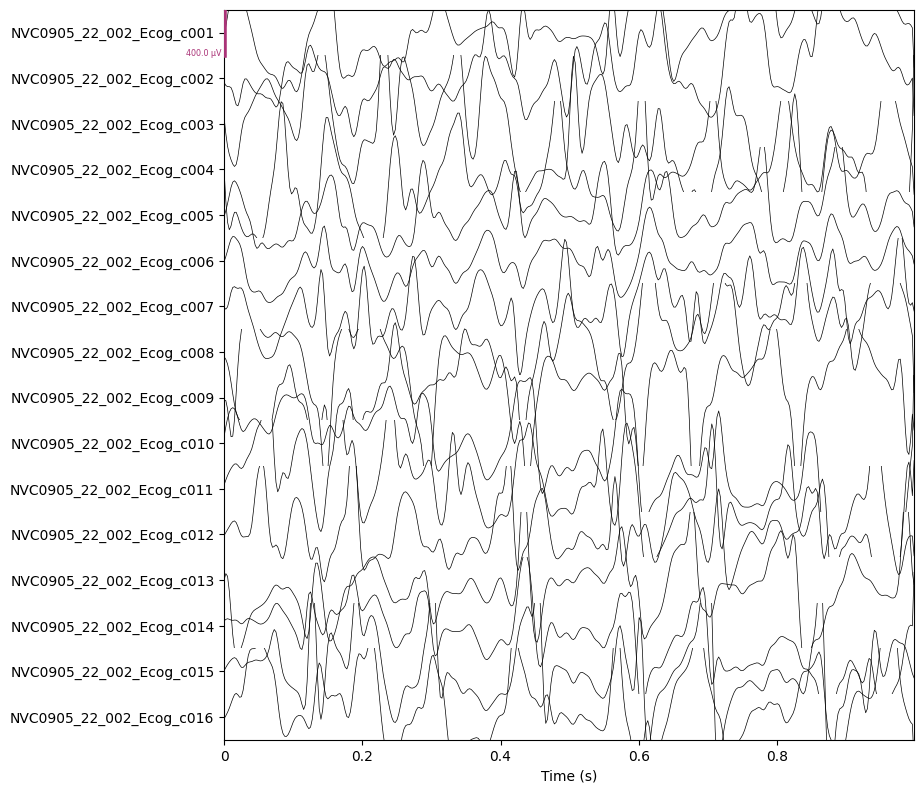

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_1/Dog_1_interictal_segment_117.mat
Creating RawArray with float64 data, n_channels=16, n_times=400
    Range : 0 ... 399 =      0.000 ...     0.998 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



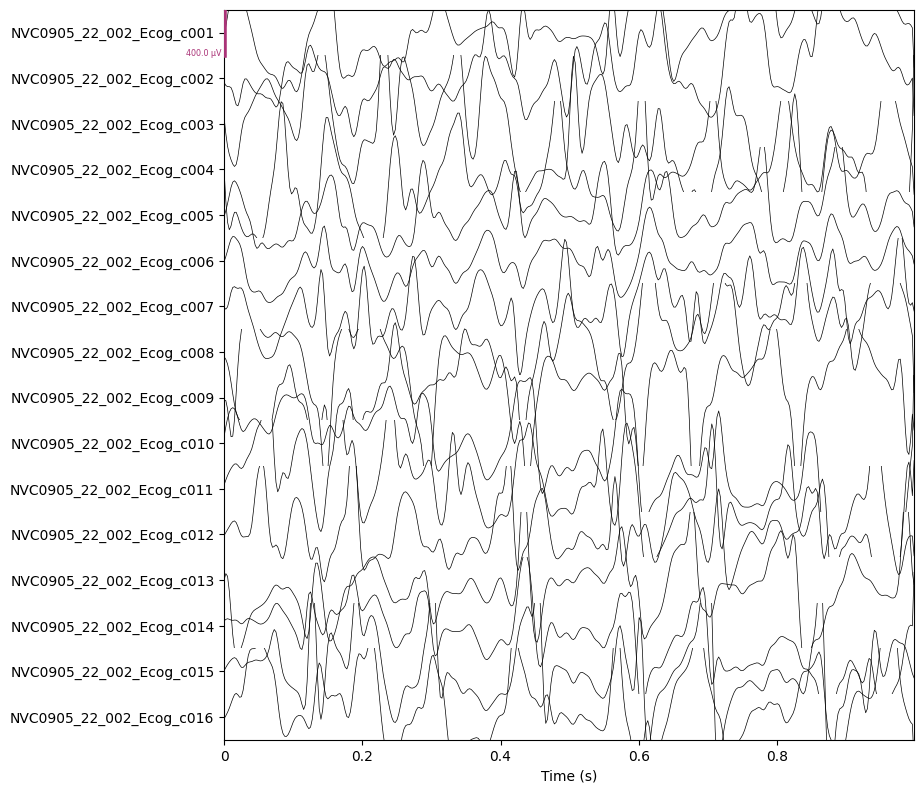

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_2473.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_1069.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_238.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_1157.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_1575.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_897.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_825.mat', '/content/dataset/Volumes/Seagate/seizure_d

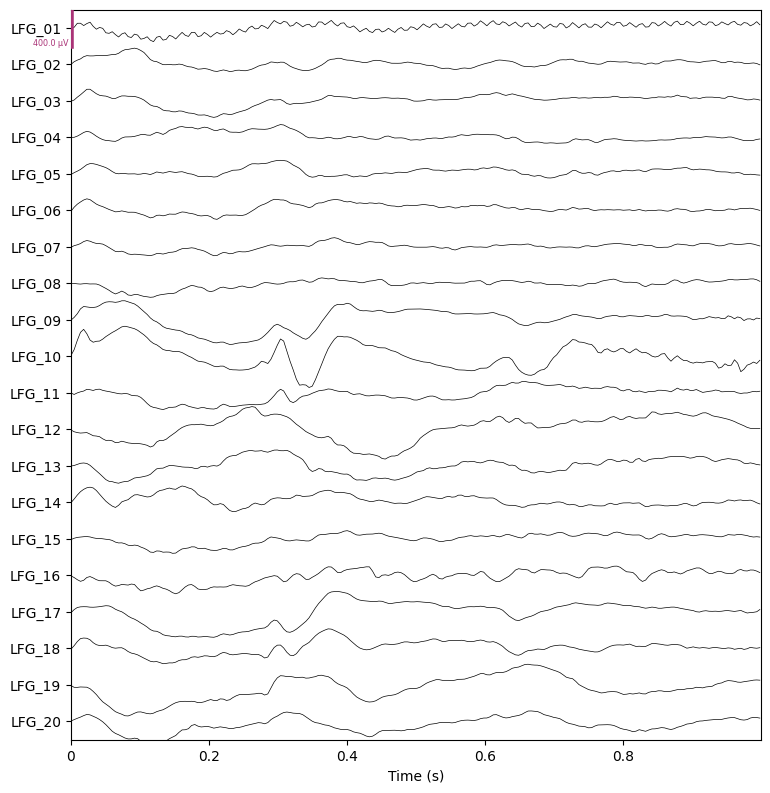

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_5/Patient_5_interictal_segment_521.mat
Creating RawArray with float64 data, n_channels=64, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



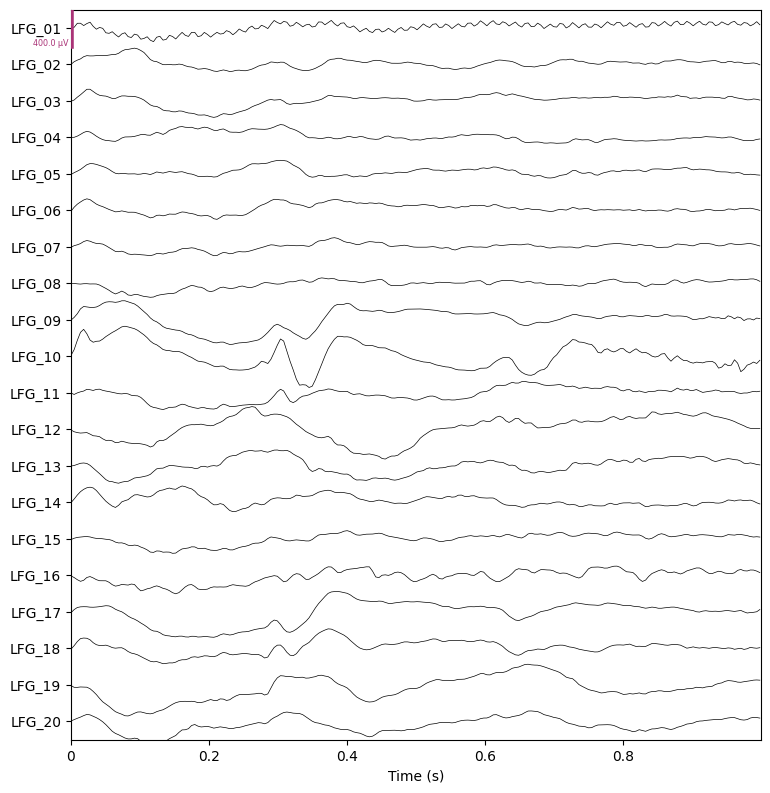

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_2615.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_670.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_523.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_1230.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_2080.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_2594.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_541.mat', '/content/dataset/Volumes/Seagate/seizure_d

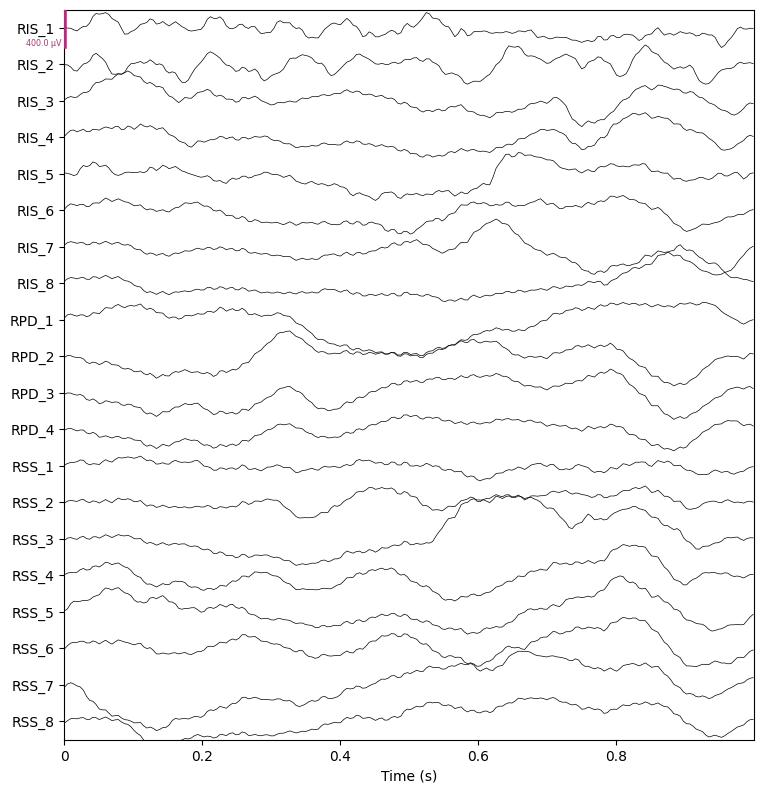

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_7/Patient_7_interictal_segment_2049.mat
Creating RawArray with float64 data, n_channels=36, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



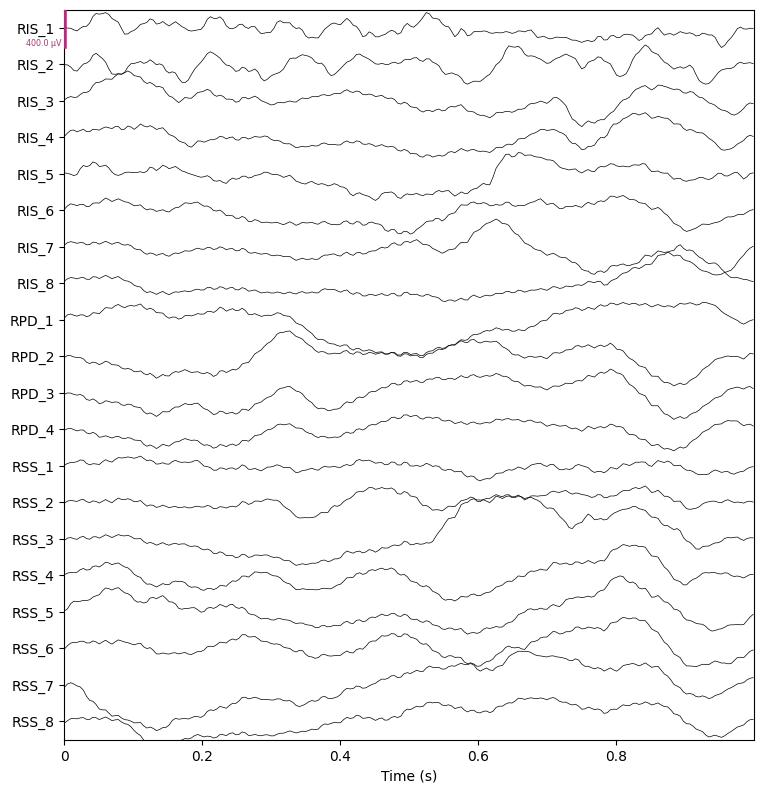

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_2329.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_1086.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_2525.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_2285.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_821.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_2629.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_1557.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_seg

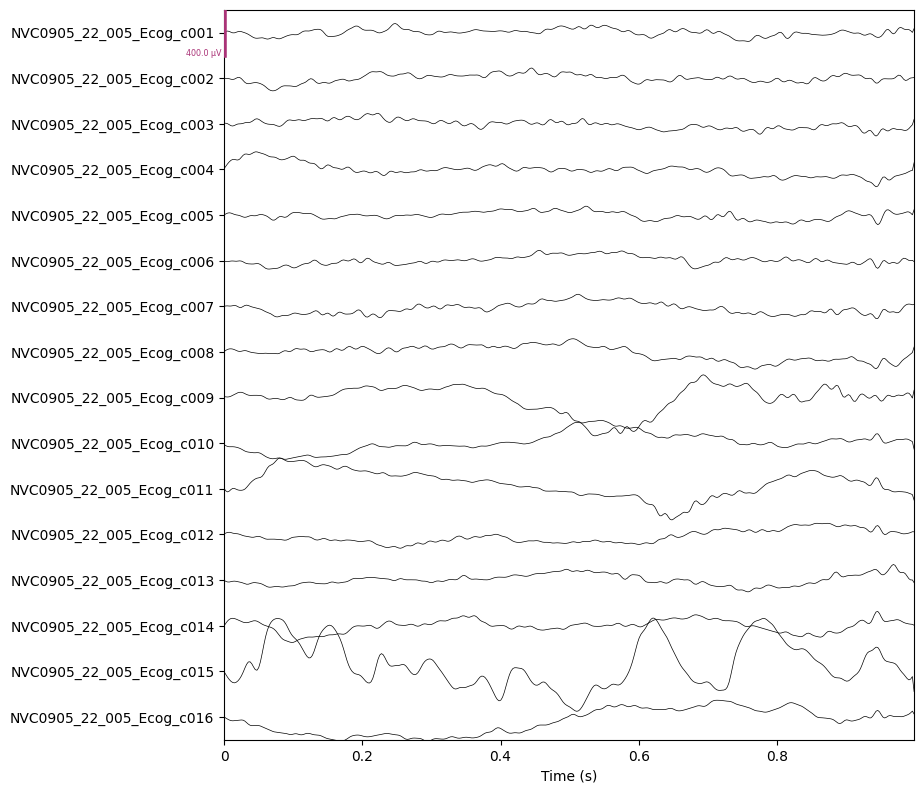

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_4/Dog_4_interictal_segment_1991.mat
Creating RawArray with float64 data, n_channels=16, n_times=400
    Range : 0 ... 399 =      0.000 ...     0.998 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



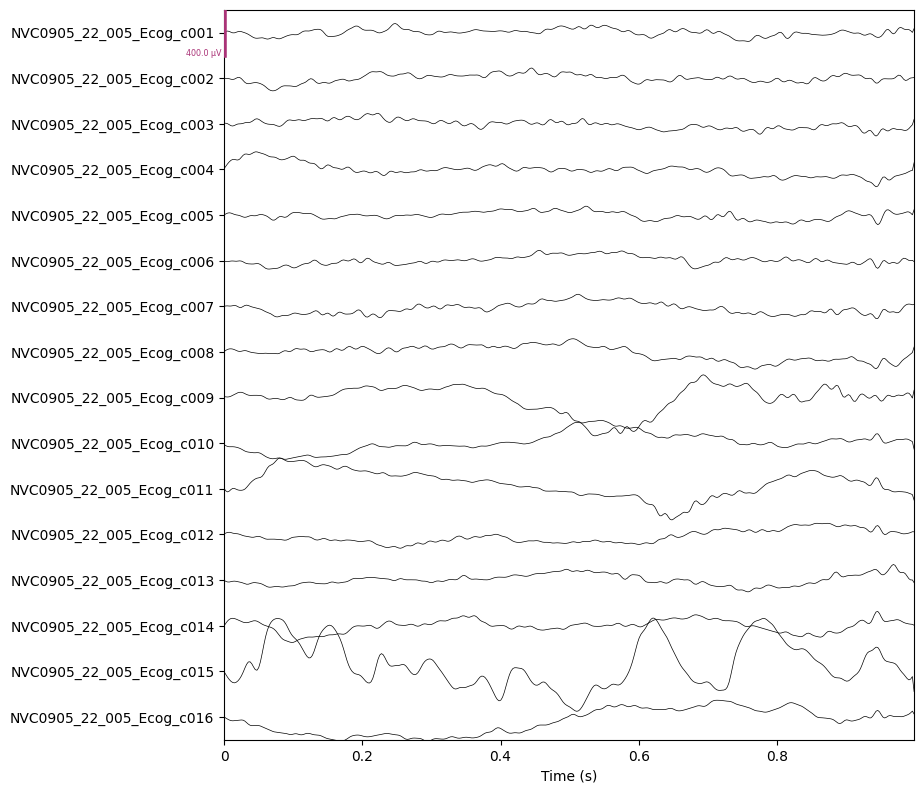

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_79.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_81.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_59.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_90.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_60.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_125.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_177.mat', '/content/dataset/Volumes/Seagate/seizure_detection/

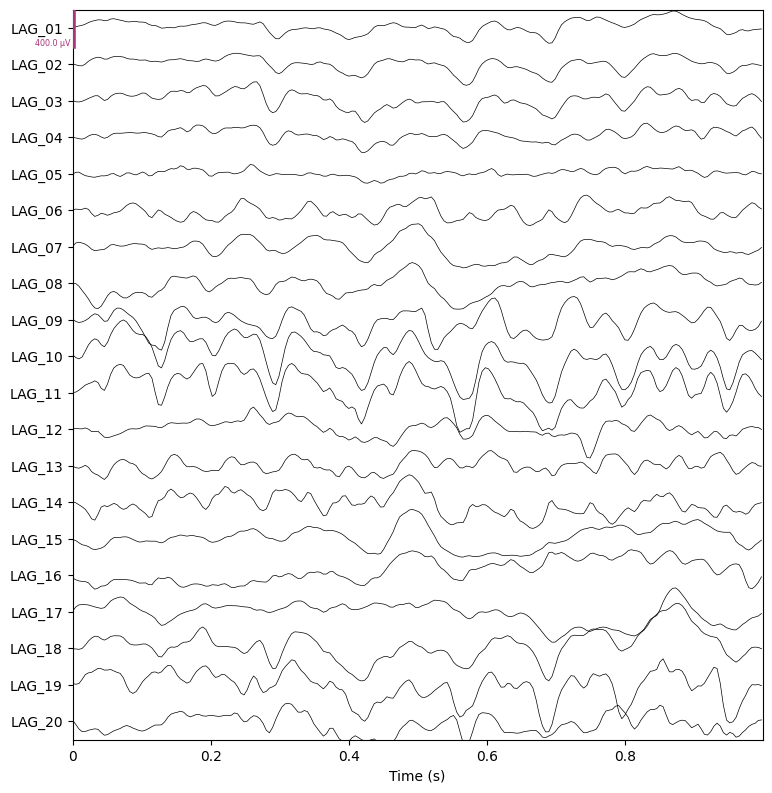

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_interictal_segment_1.mat
Creating RawArray with float64 data, n_channels=72, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



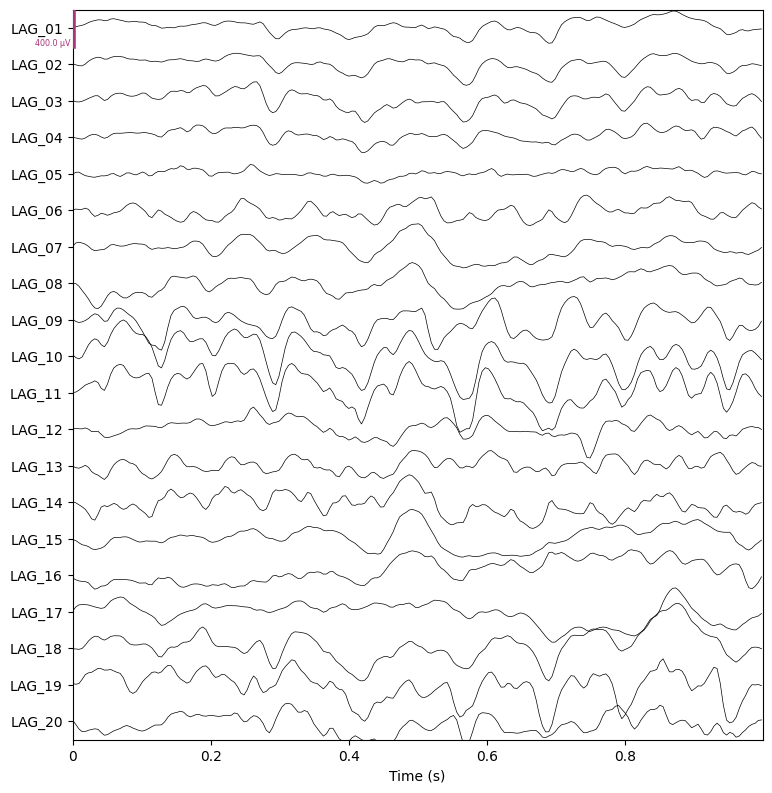

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_1202.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_605.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_1058.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_556.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_149.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_2738.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_961.mat', '/content/dataset/Volumes/Seagate/seizure_de

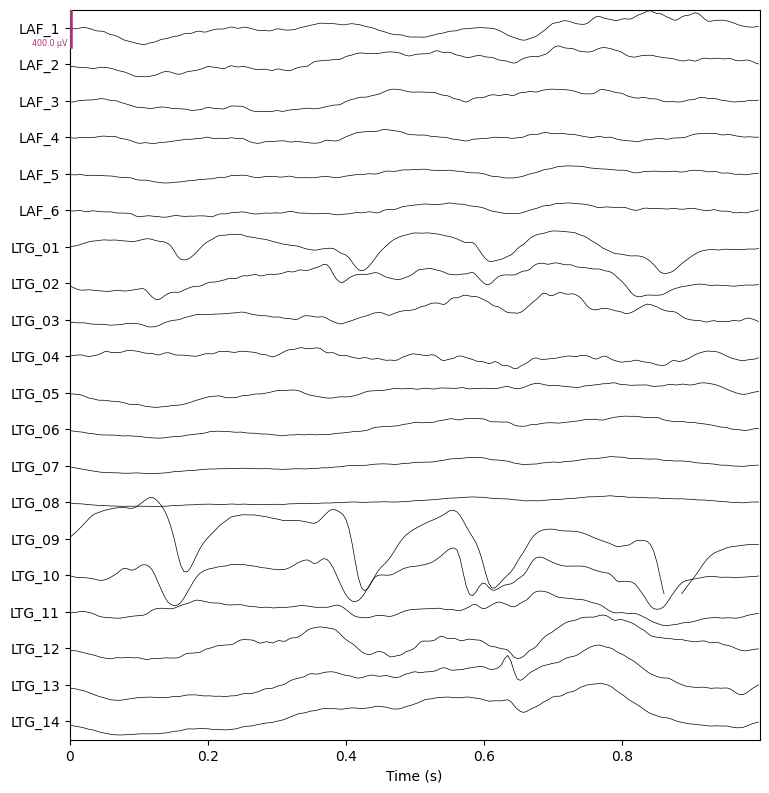

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_6/Patient_6_interictal_segment_522.mat
Creating RawArray with float64 data, n_channels=30, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



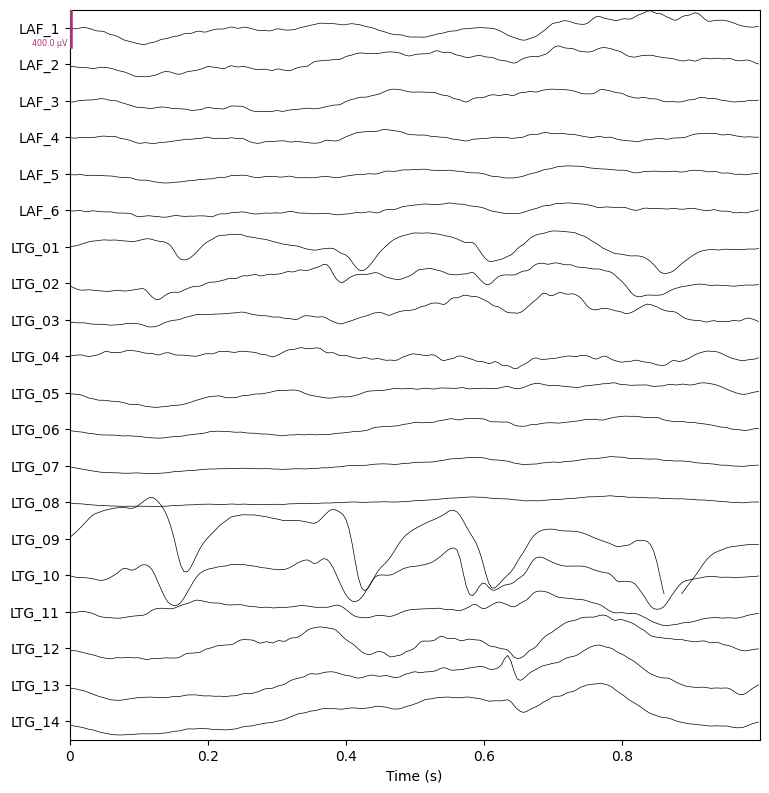

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1231.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1071.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_538.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1179.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1628.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1298.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_326.mat', '/content/dataset/Volumes/Seagate/seizure_

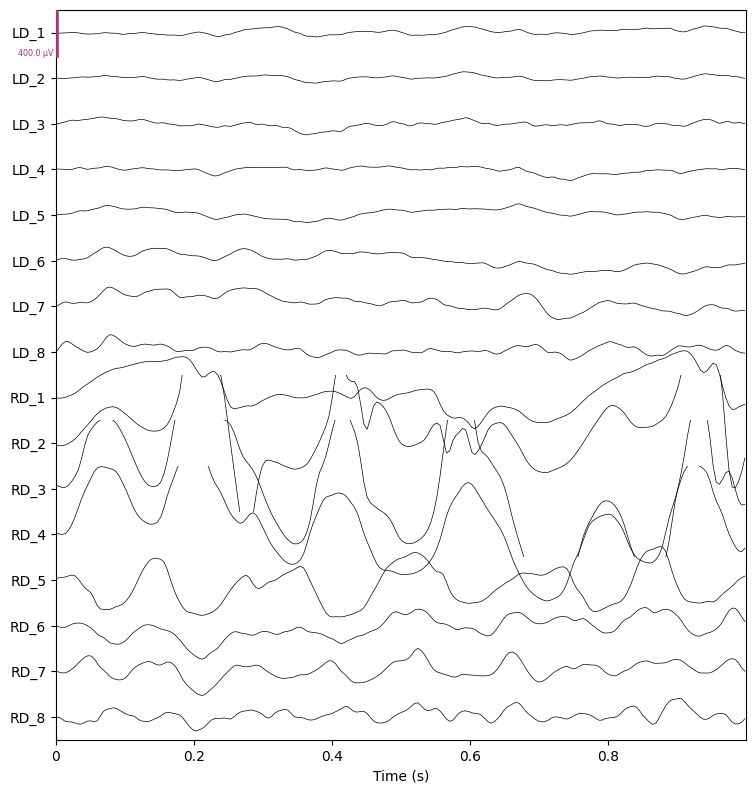

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1216.mat
Creating RawArray with float64 data, n_channels=16, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



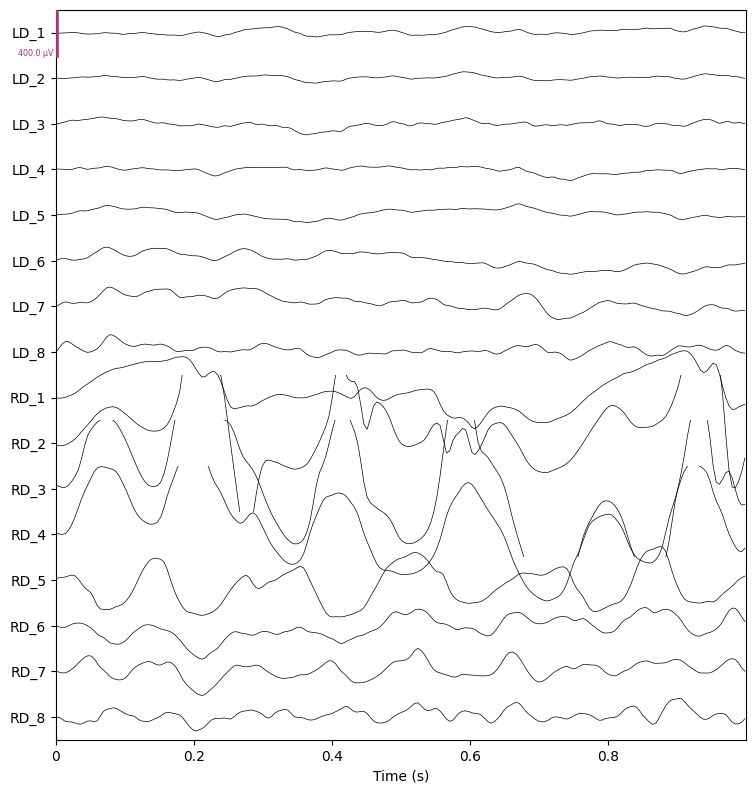

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/.DS_Store
Random ICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_ictal_segment_89.mat
Creating RawArray with float64 data, n_channels=16, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Random ICTAL file: <Info | 7 non-empty values
 bads: []
 ch_names: LD_1, LD_2, LD_3, LD_4, LD_5, LD_6, LD_7, LD_8, RD_1, RD_2, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 5000.0 Hz
>
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



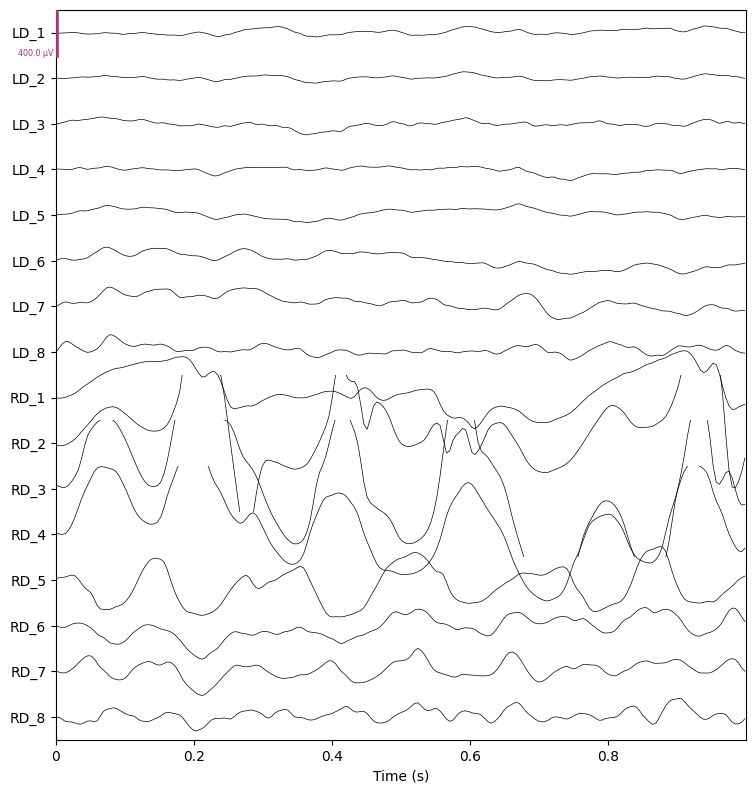

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_8/Patient_8_interictal_segment_1216.mat
Creating RawArray with float64 data, n_channels=16, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



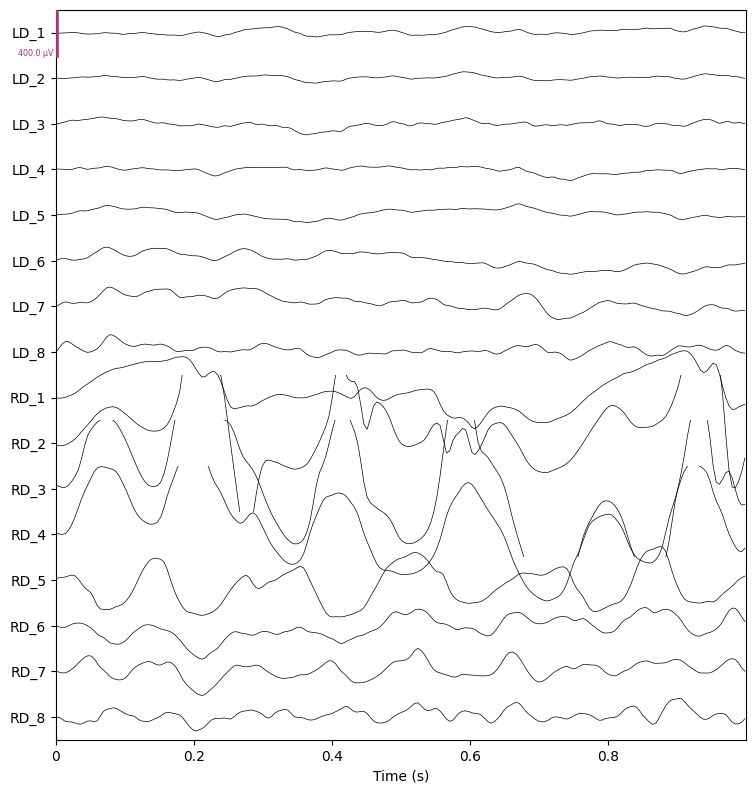

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_337.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_71.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_932.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_102.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_1114.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_508.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_51.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_86

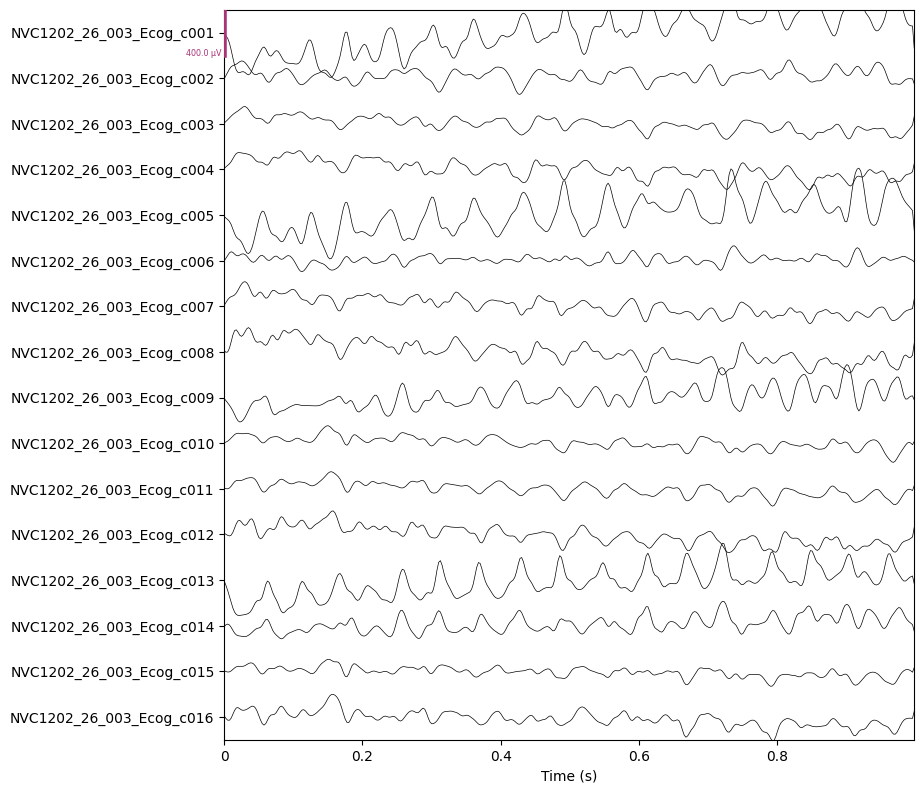

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Dog_2/Dog_2_interictal_segment_872.mat
Creating RawArray with float64 data, n_channels=16, n_times=400
    Range : 0 ... 399 =      0.000 ...     0.998 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



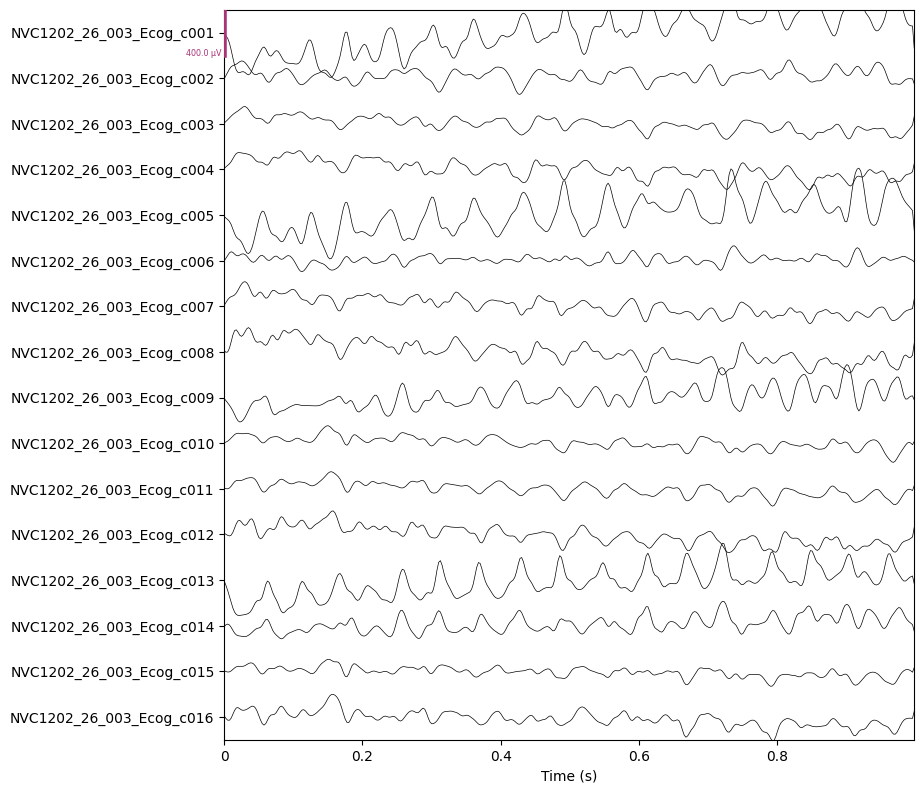

/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2
['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_1041.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_1113.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_1620.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_257.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_194.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_1019.mat', '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_2675.mat', '/content/dataset/Volumes/Seagate/seizure_

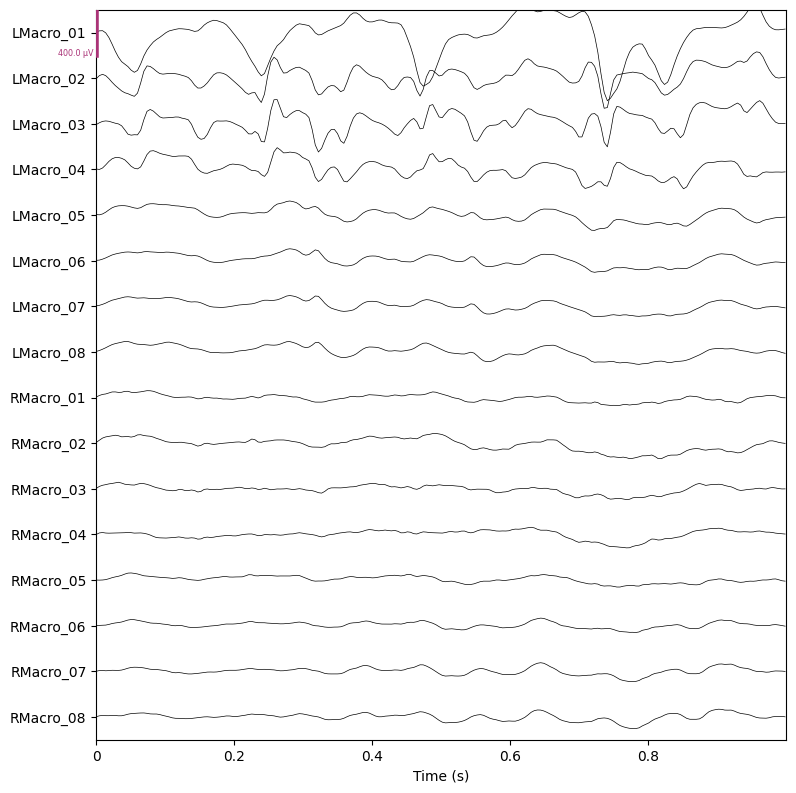

Random INTERICTAL file: /content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_1880.mat
Creating RawArray with float64 data, n_channels=16, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     1.000 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



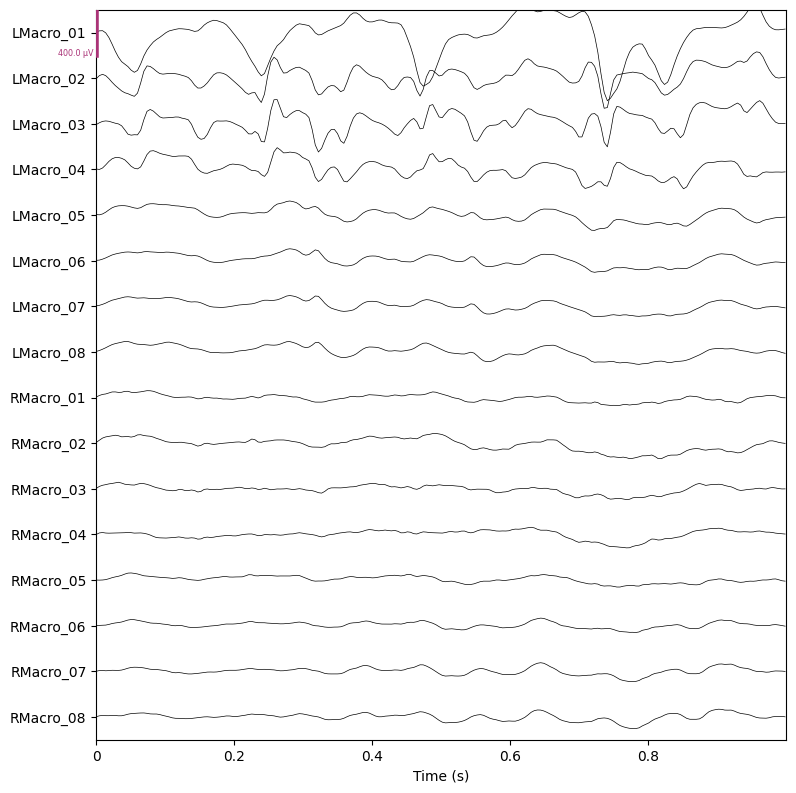

In [ ]:
top_directory = extracted_dir_path+'/Volumes/Seagate/seizure_detection/competition_data/clips'
file_paths_dict = {}
for subfolder in os.listdir(top_directory):
    subfolder_path = os.path.join(top_directory, subfolder)
    print(subfolder_path)
    if os.path.isdir(subfolder_path):
      ictal_files, interictal_files = find_ictal_and_interictal(subfolder_path)
      random_ictal_file = random.choice(ictal_files)
      random_interictal_file = random.choice(interictal_files)

      # Store the file paths in the dictionary with the folder name as the key to use later
      file_paths_dict[subfolder] = {
          'ictal': ictal_files,
          'interictal': interictal_files
      }

    df_ictal, freq_ictal = mat_to_df(random_ictal_file)
    df_interictal, freq_interictal = mat_to_df(random_ictal_file)

    print("Random ICTAL file:", random_ictal_file)
    ictal = create_mne_object(df_ictal, freq_ictal)
    ictal.plot(**args)
    print("Random INTERICTAL file:", random_interictal_file)
    interictal = create_mne_object(df_interictal, freq_interictal)
    interictal.plot(**args)


In [ ]:
file_paths_dict['Patient_4']['ictal']

['/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_6.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_4.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_14.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_2.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_5.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_16.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_19.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_4/Patient_4_ictal_segment_20.mat',
 '/content/dataset/Volumes/Seagate/seizure_detection

In [ ]:
# for file_name in file_paths_dict['Patient_4']['interictal']:
#   df_ictal, freq_ictal = mat_to_df(file_name)
#   df_interictal, freq_interictal = mat_to_df(random_ictal_file)
#   channels_list = []
#   ictal = create_mne_object(df_ictal, freq_ictal)
#   interictal = create_mne_object(df_interictal, freq_ictal)
#   channels_list.append(set(ictal.ch_names))
#   channels_list.append(set(interictal.ch_names))

# if len(set(map(tuple, channels_list))) == 1:
#   print("All files have the same channels: True")
# else:
#   print("All files have the same channels: False")

Apply FFT transformation: For each file, it loads the EEG data, transposes it to have time as rows and channels as columns, and then applies the Fast Fourier Transform (FFT) to each channel across all time points. This results in a matrix of complex numbers representing the frequency components of the signal.

Slice frequencies: It selects the frequencies in the range 1 to 47Hz from the FFT result. This range was chosen based on trial and error for dimensionality reduction.

Take log10 of magnitudes: The function takes the absolute value of the FFT result to get magnitudes and then applies the log10 transformation. This is helpful for scaling.

Create DataFrame: It converts the resulting feature matrix into a Pandas DataFrame. Each row corresponds to a 1-second EEG clip for a specific channel, and each column represents a frequency bin in the specified range. The last column 'label' is added to indicate whether the clip is ictal (1) or interictal (0).

In [ ]:
def extract_eeg_features(file_dict):
    data_list = []

    for label, files in file_dict.items():
        for file in files:
            df, _ = mat_to_df(file)

            # Apply FFT to each channel (row) across all time points
            fft_result = np.abs(np.fft.fft(df.iloc[:, :-1], axis=1))

            # Slice frequencies in the range 1 to 47Hz
            freq_slice = slice(1, 48)

            # Take log10 of the magnitudes
            fft_features = np.log10(fft_result[:, freq_slice])
            fft_features = pd.DataFrame(fft_features)

            mean_values = np.mean(df.iloc[:, :-1], axis=1)
            median_values = np.median(df.iloc[:, :-1], axis=1)
            std_dev_values = np.std(df.iloc[:, :-1], axis=1)
            skewness_values = skew(df.iloc[:, :-1], axis=1)
            kurtosis_values = kurtosis(df.iloc[:, :-1], axis=1)

            # Concatenate statistical features to the dataframe
            stat_features = pd.DataFrame({
                'mean': mean_values,
                'median': median_values,
                'std_dev': std_dev_values,
                'skewness': skewness_values,
                'kurtosis': kurtosis_values
            })

            # Concatenate all features
            features = pd.concat([fft_features, stat_features], axis=1)
            del fft_features, stat_features
            # Add label (1 for ictal, 0 for interictal) as a new column
            features['label'] = np.where(label == 'ictal', 1, 0)

            data_list.append(features)

    feature_df = pd.concat(data_list, ignore_index=True)
    del data_list, features
    return feature_df

# Training Models

In [ ]:
def split_data(data, test_size=0.2, random_state=42):
    X = data.drop(columns=['label'])
    y = data['label']
    # Use stratified sampling to maintain the distribution of 'ictal' and 'interictal'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

In [ ]:
def train_xgboost_model(X_train, y_train, params=None):
    if params is None:
        params = {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'eval_metric': 'logloss'}

    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain)

    return model


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.round(y_pred_prob)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    del X_test, y_pred_prob, y_pred, y_test

    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}\n")

    return accuracy

In [ ]:
# Creating a dictionary patient_data_dict with extracted features data
patient_data_dict = {}

for patient, person_file_dict in file_paths_dict.items():
    print(f"\nExtracting features for {patient}:\n")
    data = extract_eeg_features(person_file_dict)
    patient_data_dict[patient] = data
    del data



Extracting features for Patient_1:


Extracting features for Dog_3:


Extracting features for Patient_3:


Extracting features for Dog_1:


Extracting features for Patient_5:


Extracting features for Patient_7:


Extracting features for Dog_4:


Extracting features for Patient_4:


Extracting features for Patient_6:


Extracting features for Patient_8:


Extracting features for Dog_2:


Extracting features for Patient_2:



In [ ]:
del file_paths_dict

In [ ]:
all_accuracies = []
for patient, data in patient_data_dict.items():
    print(f"\Training models for {patient}:\n")
    data = data.astype(float)
    X_train, X_test, y_train, y_test = split_data(data)
    del data
    xgboost_model = train_xgboost_model(X_train, y_train)
    del X_train
    del y_train
    # Evaluate accuracy for the current patient
    dtest = xgb.DMatrix(X_test)
    xgboost_accuracy = evaluate_model(xgboost_model, dtest, y_test)
    del X_test
    del y_test

    all_accuracies.append(xgboost_accuracy)


# Calculate the average accuracy across all patients
average_accuracy = np.mean(all_accuracies)
print(f"Average Accuracy Across All Patients: {average_accuracy}")


\Training models for Patient_1:

Accuracy: 0.7900574712643678
AUC: 0.8119260370879122

\Training models for Dog_3:

Accuracy: 0.9436975190839695
AUC: 0.9258832351299895

\Training models for Patient_3:

Accuracy: 0.6956359269932757
AUC: 0.694904734450355

\Training models for Dog_1:

Accuracy: 0.8344798657718121
AUC: 0.8872877466265254

\Training models for Patient_5:

Accuracy: 0.951247358834244
AUC: 0.7420904131360861

\Training models for Patient_7:

Accuracy: 0.9266958250497018
AUC: 0.7777946756802621

\Training models for Dog_4:

Accuracy: 0.9335534952412209
AUC: 0.7894196565389524

\Training models for Patient_4:

Accuracy: 0.9047619047619048
AUC: 0.9121991157894735

\Training models for Patient_6:

Accuracy: 0.924924924924925
AUC: 0.8491205084511785

\Training models for Patient_8:

Accuracy: 0.945005291005291
AUC: 0.924554190808967

\Training models for Dog_2:

Accuracy: 0.8734564393939394
AUC: 0.6594458539972196

\Training models for Patient_2:

Accuracy: 0.9519261381725566
AU

In [ ]:
def train_random_forest_cv(X, y, n_estimators=100, cv=5, random_state=42):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    fold_accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model.fit(X_train, y_train)

        fold_accuracy = rf_model.score(X_test, y_test)
        fold_accuracies.append(fold_accuracy)

        del X_train, X_test, y_train, y_test

    average_accuracy = np.mean(fold_accuracies)
    print(average_accuracy)
    del rf_model, fold_accuracies

    return average_accuracy

In [ ]:
# all_accuracies_rf = []
# for patient, data in patient_data_dict.items():
#     print(f"Training Random Forest for {patient}:\n")
#     data = data.astype(float)
#     X_train, X_test, y_train, y_test = split_data(data)
#     del data
#     rf_accuracy = train_random_forest_cv(X_train, y_train)
#     del X_train, y_train
#     all_accuracies_rf.append(rf_accuracy)

# average_accuracy_rf = np.mean(all_accuracies_rf)
# print(f"Average Accuracy Across All Patients (Random Forest): {average_accuracy_rf}")

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

all_accuracies = []

for patient, data in patient_data_dict.items():
    print(f"{patient}:\n")

    data = data.astype(float)
    data.columns = data.columns.astype(str)
    X_train, X_test, y_train, y_test = split_data(data)
    del data

    # Create and train the ExtraTreesClassifier model
    extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    extra_trees_model.fit(X_train, y_train)
    del X_train
    del y_train

    y_pred_prob = extra_trees_model.predict_proba(X_test)[:, 1]
    y_pred = np.round(y_pred_prob)

    etc_accuracy = evaluate_model(extra_trees_model, X_test, y_test)
    del X_test
    del y_test
    all_accuracies.append(etc_accuracy)

# Calculate the average accuracy across all patients
average_accuracy = np.mean(all_accuracies)
print(f"Average Accuracy Across All Patients: {average_accuracy}")


Patient_1:

Accuracy: 0.9187931034482759
AUC: 0.8990714285714285

Dog_3:

Accuracy: 0.9549570610687023
AUC: 0.7978692883403361

Patient_3:

Accuracy: 0.9999798270893372
AUC: 0.9999728625395112

Dog_1:

Accuracy: 0.8946728187919463
AUC: 0.8356005725498629

Patient_5:

Accuracy: 0.9999668488160292
AUC: 0.999662962962963

Patient_7:

Accuracy: 0.999964498721954
AUC: 0.9997816061563524

Dog_4:

Accuracy: 0.9444576632753529
AUC: 0.6746521327559517

Patient_4:

Accuracy: 1.0
AUC: 1.0

Patient_6:

Accuracy: 0.999995995995996
AUC: 0.9999733333333334

Patient_8:

Accuracy: 0.9938523809523809
AUC: 0.9683513157894736

Dog_2:

Accuracy: 0.8885227272727273
AUC: 0.579745360991816

Patient_2:

Accuracy: 0.994694364851958
AUC: 0.9451637245564687

Average Accuracy Across All Patients: 0.9658214408570549


Observations:

**XGBoost with only FFT transformation** -
Patient_1:

XGBoost - Accuracy: 0.7910344827586206
XGBoost - AUC: 0.7973069642857142

Dog_3:

XGBoost - Accuracy: 0.941956106870229
XGBoost - AUC: 0.9183539993927258

Patient_3:

XGBoost - Accuracy: 0.6858789625360231
XGBoost - AUC: 0.6870688027265952

Dog_1:

XGBoost - Accuracy: 0.8338926174496645
XGBoost - AUC: 0.8844335338993871

Patient_5:

XGBoost - Accuracy: 0.9508196721311475
XGBoost - AUC: 0.6715664502398186

Patient_7:

XGBoost - Accuracy: 0.9231831865947174
XGBoost - AUC: 0.7732055708891412

Dog_4:

XGBoost - Accuracy: 0.9301074827699376
XGBoost - AUC: 0.7421295248499016

Patient_4:

XGBoost - Accuracy: 0.905647619047619
XGBoost - AUC: 0.9139963084210527

Patient_6:

XGBoost - Accuracy: 0.9251528194861528
XGBoost - AUC: 0.8525205152725669

Patient_8:

XGBoost - Accuracy: 0.9306608465608466
XGBoost - AUC: 0.906929595802469

Dog_2:

XGBoost - Accuracy: 0.8696969696969697
XGBoost - AUC: 0.6351330161846183

Patient_2:

XGBoost - Accuracy: 0.9519261381725566
XGBoost - AUC: 0.852606705284724

Average Accuracy Across All Patients: 0.8866630753395403

With Statistical features average acuracy  = 0.8896201800414341


Extra Trees classifier

Patient_1:

Accuracy: 0.9187931034482759
AUC: 0.8990714285714285

Dog_3:

Accuracy: 0.9549570610687023
AUC: 0.7978692883403361

Patient_3:

Accuracy: 0.9999798270893372
AUC: 0.9999728625395112

Dog_1:

Accuracy: 0.8946728187919463
AUC: 0.8356005725498629

Patient_5:

Accuracy: 0.9999668488160292
AUC: 0.999662962962963

Patient_7:

Accuracy: 0.999964498721954
AUC: 0.9997816061563524

Dog_4:

Accuracy: 0.9444576632753529
AUC: 0.6746521327559517

Patient_4:

Accuracy: 1.0
AUC: 1.0

Patient_6:

Accuracy: 0.999995995995996
AUC: 0.9999733333333334

Patient_8:

Accuracy: 0.9938523809523809
AUC: 0.9683513157894736

Dog_2:

Accuracy: 0.8885227272727273
AUC: 0.579745360991816

Patient_2:

Accuracy: 0.994694364851958
AUC: 0.9451637245564687

Average Accuracy Across All Patients: 0.9658214408570549